# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [2]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse
import geoalchemy2 as gdb
from geoalchemy2 import WKTElement
from geoalchemy2 import Geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
from sqlalchemy import create_engine, text
import numpy as np
from shapely import wkt
import psycopg2

from sqlalchemy.orm import declarative_base

In [45]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
#DATA_DIR = pathlib.Path("data")
DATA_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp" 
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"


NYC_DATA_APP_TOKEN = "ViHT9fZpI3IQw23Bqm2tTgCVE"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Final_project"
DB_USER = "postgres"
DB_PASSWORD = "yq001018"
DB_HOST = "localhost"  
DB_PORT = "5432" 

DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/queries")
#QUERY_DIR = pathlib.Path("queries")

# 2015-01-01
endpoint_311 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?\
$select= unique_key, created_date,incident_zip,complaint_type&\
$where= created_date between '2022-10-01' and'2023-10-01'&$limit=355000&\
$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                 "$select=tree_id,the_geom,zipcode,zip_city,health,spc_common&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"

## Part 1: Data Preprocessing

In [4]:
def load_and_clean_zipcodes():
    zipcodes_df = gpd.read_file(ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df[zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df[["ZIPCODE","geometry"]]
    zipcodes_df.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    return zipcodes_df[["zipcode","geometry"]]

In [15]:
def download_and_clean_311_data():
    content = requests.get(endpoint_311)
    data_311 = gpd.read_file(content.text)
    data_311.rename(columns={data_311.columns[2]: 'zipcode'}, inplace=True)
    return data_311[["unique_key","created_date","zipcode","complaint_type"]]

In [16]:
def download_and_clean_tree_data():
    content = requests.get(endpoint_trees)
    data_tree = gpd.read_file(content.text).reset_index()
    data_tree.rename(columns={data_tree.columns[4]: 'species'}, inplace=True)
    data_tree.rename(columns={data_tree.columns[6]: 'geometry'}, inplace=True)
    return data_tree[["tree_id","geometry","zipcode","health","species"]]

In [17]:
def load_and_clean_zillow_data():
    zillow_df = gpd.read_file(ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] == 'New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']

    for col in date_columns:
        zillow_df[col] = pd.to_numeric(zillow_df[col], errors='coerce')
    zillow_df.rename(columns={'RegionID': 'regionid'},inplace=True)
    zillow_df.rename(columns={'RegionName': 'zipcode'},inplace=True)
    return zillow_df[["regionid",'zipcode'] + date_columns]

In [18]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [19]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [20]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 110 entries, 21 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   zipcode   110 non-null    object  
 1   geometry  110 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.6+ KB


In [21]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,zipcode,geometry
21,10034,"POLYGON ((1006203.169 257345.657, 1006214.666 ..."
22,10033,"POLYGON ((1003020.865 256049.162, 1003096.046 ..."
24,10040,"POLYGON ((1002564.135 253724.773, 1002596.698 ..."
32,10032,"POLYGON ((998935.853 249154.260, 998945.457 24..."
36,10031,"POLYGON ((1000830.039 241801.590, 1000913.103 ..."


In [22]:
geodf_311_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355000 entries, 0 to 354999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unique_key      355000 non-null  object        
 1   created_date    355000 non-null  datetime64[ns]
 2   zipcode         348105 non-null  object        
 3   complaint_type  355000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 10.8+ MB


In [23]:
geodf_311_data.head()

,unique_key,created_date,zipcode,complaint_type
0,58974915,2023-09-30 23:59:58,11226,Noise - Street/Sidewalk
1,58972386,2023-09-30 23:59:38,11361,Noise - Residential
2,58973465,2023-09-30 23:59:35,10002,Noise - Commercial
3,58974769,2023-09-30 23:59:34,11435,Noise - Residential
4,58968700,2023-09-30 23:59:28,11226,Noise - Residential


In [24]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64488 entries, 0 to 64487
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tree_id   64488 non-null  object  
 1   geometry  64488 non-null  geometry
 2   zipcode   64488 non-null  object  
 3   health    61495 non-null  object  
 4   species   61496 non-null  object  
dtypes: geometry(1), object(4)
memory usage: 2.5+ MB


In [25]:
geodf_tree_data.head()

,tree_id,geometry,zipcode,health,species
0,190422,POINT (-73.98495 40.77005),10023,Good,honeylocust
1,190426,POINT (-73.98534 40.77021),10023,Good,honeylocust
2,208649,POINT (-73.98730 40.76272),10019,Good,American linden
3,193310,POINT (-73.96046 40.77217),10021,Good,honeylocust
4,199760,POINT (-73.98096 40.78209),10024,Fair,willow oak


In [26]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 4 to 6721
Columns: 107 entries, regionid to 2023-09-30
dtypes: float64(105), object(2)
memory usage: 122.3+ KB


In [27]:
df_zillow_data.head()

,regionid,zipcode,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
4,62093,11385,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,2264.966715,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
6,62019,11208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
12,62046,11236,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
13,61807,10467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
14,62085,11373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


## Part 2: Storing Data

In [ ]:
#!createdb Final_project

In [ ]:
#!psql --dbname Final_project -c 'CREATE EXTENSION postgis;'

In [82]:
# Connect to pgsl
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [29]:
engine = db.create_engine(DB_URL)

In [30]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        zipcode VARCHAR,
        the_geom GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        unique_key INTEGER PRIMARY KEY,
        created_date DATE,
        zipcode VARCHAR,
        complaint_type VARCHAR
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY,
        health VARCHAR,
        species VARCHAR
    )
    """

date_col = [f'"{col}" REAL' for col in df_zillow_data.columns if col.startswith('20')]

ZILLOW_SCHEMA = f"""
CREATE TABLE IF NOT EXISTS rent (
    regionid INTEGER PRIMARY KEY,
    zipcode VARCHAR,
    {', '.join(date_col)}
)
"""

In [31]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [32]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 1: SQL

In [33]:
def write_dataframes_to_table(tablename_to_dataframe):
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            temp_df = dataframe
            temp_df['the_geom'] = temp_df['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None)
            temp_df.drop('geometry',axis=1,inplace=True)
            temp_df.to_sql(tablename, engine, if_exists='replace', index=False, 
                             dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}) 
            
        else:
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [34]:
tablename_to_dataframe = {
    "zip_codes": geodf_zipcode_data,
    "nyc_311": geodf_311_data,
    "trees": geodf_tree_data,
    "rent": df_zillow_data,
}

In [35]:
write_dataframes_to_table(tablename_to_dataframe)

In [85]:
cur = conn.cursor() #connect to cursor
cur.execute("SELECT * FROM rent LIMIT 1;")

In [86]:
rows = cur.fetchall()
for row in rows:
    print(row)
#spc_common

('62093', '11385', None, 2087.527084354236, None, 2149.9242522176696, 2166.2636978114047, 2148.9928856397355, 2190.098590663059, 2264.9667154092986, 2297.9009165932744, 2267.061704891128, 2225.8900597492384, 2188.28767356946, 2189.3470387304583, 2255.28377072397, 2267.36974971921, 2296.9999529002107, 2272.544133770503, 2282.492009139728, 2313.009450540561, 2334.460177809979, 2378.91044942648, 2397.294201281098, 2357.959208546377, 2338.575627078289, 2319.1708873161115, 2344.361311624835, 2345.0766325036943, 2333.9067668124885, 2343.39574731235, 2332.2285297605845, 2351.643160135104, 2346.7606154580044, 2391.4482353885464, 2366.9753754223325, 2376.8141179668, 2349.812498667744, 2340.667650568317, 2309.4949644028893, 2311.3902280710354, 2326.9186873489643, 2358.4724286814003, 2367.4564389822563, 2382.3846710777743, 2386.107852213686, 2401.5251931345742, 2419.898399284853, 2420.804473714676, 2420.254365648151, 2400.882443808336, 2419.3924529994074, 2407.5373017488805, 2422.886151189401, 24

In [121]:
with engine.connect() as conn:
    rows = conn.execute("SELECT * FROM zip_codes LIMIT 1").fetchall()
    for row in rows:
        print(row)

('10034', '0103000020E61000000100000093040000003F8856F6B42E410002C1400D6A0F41803502550DB52E410018A6880D6A0F4180B4C90E18B52E4100B64458126A0F4180114C3B22B52E41005 ... (37208 characters truncated) ... 42E41006ACDA0526A0F4100D44B49B3B42E41001A912C476A0F4180692EE7D0B42E4100D0613D256A0F410015AFBDDDB42E41001A186D196A0F41003F8856F6B42E410002C1400D6A0F41')


In [ ]:
# with engine.connect() as conn:
#     result = conn.execute(db.text("SELECT COUNT(*) FROM nyc_311"))
#     for row, in result:
#         print(row)

In [ ]:
# cur.execute("SELECT * FROM zip_codes LIMIT 10;")

In [ ]:
# rows = cur.fetchall()
# for row in rows:
#     print(row)

## Part 3: Understanding the Data

In [47]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1

In [48]:
QUERY_1_FILENAME = QUERY_DIR / "Q1_311compliants_per_zipcode.sql"

QUERY_1 = """
SELECT zipcode, COUNT(unique_key) as total_complaints
FROM nyc_311
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY total_complaints DESC;
"""

In [49]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

(None, 6808)
('11226', 5229)
('11385', 4886)
('10467', 4854)
('11208', 4637)
('10456', 4629)
('11201', 4380)
('11207', 4338)
('10457', 4252)
('10452', 4237)
('10468', 4058)
('10458', 3935)
('10453', 3870)
('11221', 3735)
('10019', 3658)
('11368', 3566)
('10032', 3509)
('10031', 3376)
('11216', 3315)
('11238', 3311)
('11211', 3284)
('10025', 3151)
('11206', 3149)
('11203', 3143)
('11230', 3141)
('11220', 3138)
('11235', 3109)
('11234', 3040)
('10466', 3036)
('10002', 3033)
('11222', 3029)
('11225', 3018)
('11212', 3013)
('11215', 2977)
('11101', 2975)
('11229', 2853)
('11377', 2840)
('11214', 2829)
('11237', 2827)
('11233', 2769)
('10463', 2729)
('11213', 2724)
('10460', 2708)
('11223', 2676)
('11366', 2661)
('10009', 2651)
('11218', 2623)
('10462', 2608)
('10036', 2576)
('11209', 2562)
('10027', 2553)
('11373', 2542)
('11419', 2530)
('11210', 2485)
('11204', 2482)
('11231', 2473)
('11236', 2454)
('10034', 2427)
('10003', 2395)
('10033', 2342)
('10472', 2315)
('11375', 2311)
('10011', 2

In [50]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [51]:
QUERY_2_FILENAME = QUERY_DIR / "Q2_10_zipcodes_have_the_most_trees.sql"
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [52]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [53]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [54]:
QUERY_3_FILENAME = QUERY_DIR / "Q3_the_average_rent_of_top10_trees_zipcode .sql"
QUERY_3 = """
SELECT t.zipcode, 
       ROUND(CAST(r."2023-08-31" AS NUMERIC), 2) AS August2023
FROM trees t
JOIN rent r ON t.zipcode = r.zipcode
GROUP BY t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;
"""

In [55]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10025', Decimal('4037.77'))
('10024', Decimal('3797.94'))
('10027', Decimal('3235.99'))
('10014', Decimal('4899.07'))
('10031', Decimal('2967.04'))
('10029', Decimal('2915.94'))
('10002', Decimal('4078.87'))
('10023', Decimal('4370.07'))
('10032', Decimal('2657.76'))
('10128', Decimal('3565.40'))


In [56]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

In [57]:
QUERY_4_FILENAME = QUERY_DIR / "Q4_top&bottom5_zipcodes_by_rent_with_trees_compliants_count.sql"

QUERY_4 = """
(SELECT rent.zipcode, rent."2015-01-31", total_trees, total_complaints
FROM rent
JOIN (SELECT nyc_311.zipcode, COUNT(nyc_311.unique_key) as total_complaints
            FROM nyc_311
            WHERE created_date BETWEEN '2023-01-01' AND '2023-01-31'
            GROUP BY nyc_311.zipcode
) nyc_311
ON rent.zipcode = nyc_311.zipcode
JOIN (SELECT trees.zipcode, COUNT(trees.tree_id) as total_trees
            FROM trees
            GROUP BY trees.zipcode
) trees
ON rent.zipcode = trees.zipcode
WHERE rent."2015-01-31" IS NOT NULL
ORDER BY rent."2015-01-31" DESC
LIMIT 5)
UNION
(SELECT rent.zipcode, rent."2015-01-31", total_trees, total_complaints
FROM rent
JOIN (SELECT nyc_311.zipcode, COUNT(nyc_311.unique_key) as total_complaints
            FROM nyc_311
            WHERE created_date BETWEEN '2023-01-01' AND '2023-01-31'
            GROUP BY nyc_311.zipcode
) nyc_311
ON rent.zipcode = nyc_311.zipcode
JOIN (SELECT trees.zipcode, COUNT(trees.tree_id) as total_trees
            FROM trees
            GROUP BY trees.zipcode
) trees
ON rent.zipcode = trees.zipcode
WHERE rent."2015-01-31" IS NOT NULL
ORDER BY rent."2015-01-31" ASC
LIMIT 5)
"""

In [58]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

In [59]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [67]:
QUERY_5_FILENAME = QUERY_DIR / "Q5_most_greenery.sql"
QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS total_trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains(z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [68]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [69]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [70]:
QUERY_6_FILENAME = QUERY_DIR / "Q6_trees_within_0.5miles.sql"
QUERY_6 = """
SELECT tree_id, species, health, the_geom
FROM trees
WHERE ST_DWithin(ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)',4326), the_geom::geography, 804.672)
"""

# ST_DWithin uses meters as units. 0.5 miles = 804.672 meters
# altitude 40.80737875669467 longtitude -73.96253174434912

In [71]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

('198514', 'pin oak', 'Good', '0101000020E6100000DC6D2BB7927D52C07FB64ECDB1664440')
('209919', 'London planetree', 'Good', '0101000020E6100000D97E39F4A67D52C0D011042387674440')
('209921', 'London planetree', 'Good', '0101000020E6100000CA7A7C66A87D52C0A00D43F184674440')
('203887', 'willow oak', 'Good', '0101000020E6100000BEA0426C7C7D52C0E19D2C0622674440')
('196440', 'American elm', 'Fair', '0101000020E61000008B6BE331B47D52C067C89A9CD3674440')
('209913', 'pin oak', 'Good', '0101000020E6100000A37F11C5A37D52C0124290D68F674440')
('178550', 'Norway maple', 'Good', '0101000020E61000009F987805467D52C034BBB69C48674440')
('189403', 'Callery pear', 'Fair', '0101000020E610000082EF64E6597D52C06C17C9835D674440')
('196606', 'honeylocust', 'Good', '0101000020E61000005B957A98E67D52C05F76B35756674440')
('198512', 'pin oak', 'Good', '0101000020E610000087E2EE6A967D52C0AC5F6CEAB4664440')
('196541', 'honeylocust', 'Good', '0101000020E6100000F92564B9CA7D52C0012DEDEA96674440')
('203996', 'Callery pear', 'Good

In [72]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [73]:
def plot_top_3_complaints(dataframe1):
    figure, axes = plt.subplots(figsize=(20, 10))
    axes.bar(dataframe1['complaint_type'], dataframe1['complaint_count'])

    axes.set_title("Top 3 Complaint Types for October 1st, 2022 to September 30th, 2023 ")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Complaint Count")
    
    plt.show()

In [74]:
def get_data_for_visual_1():
    V1 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V1))
        dataframe1 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe1

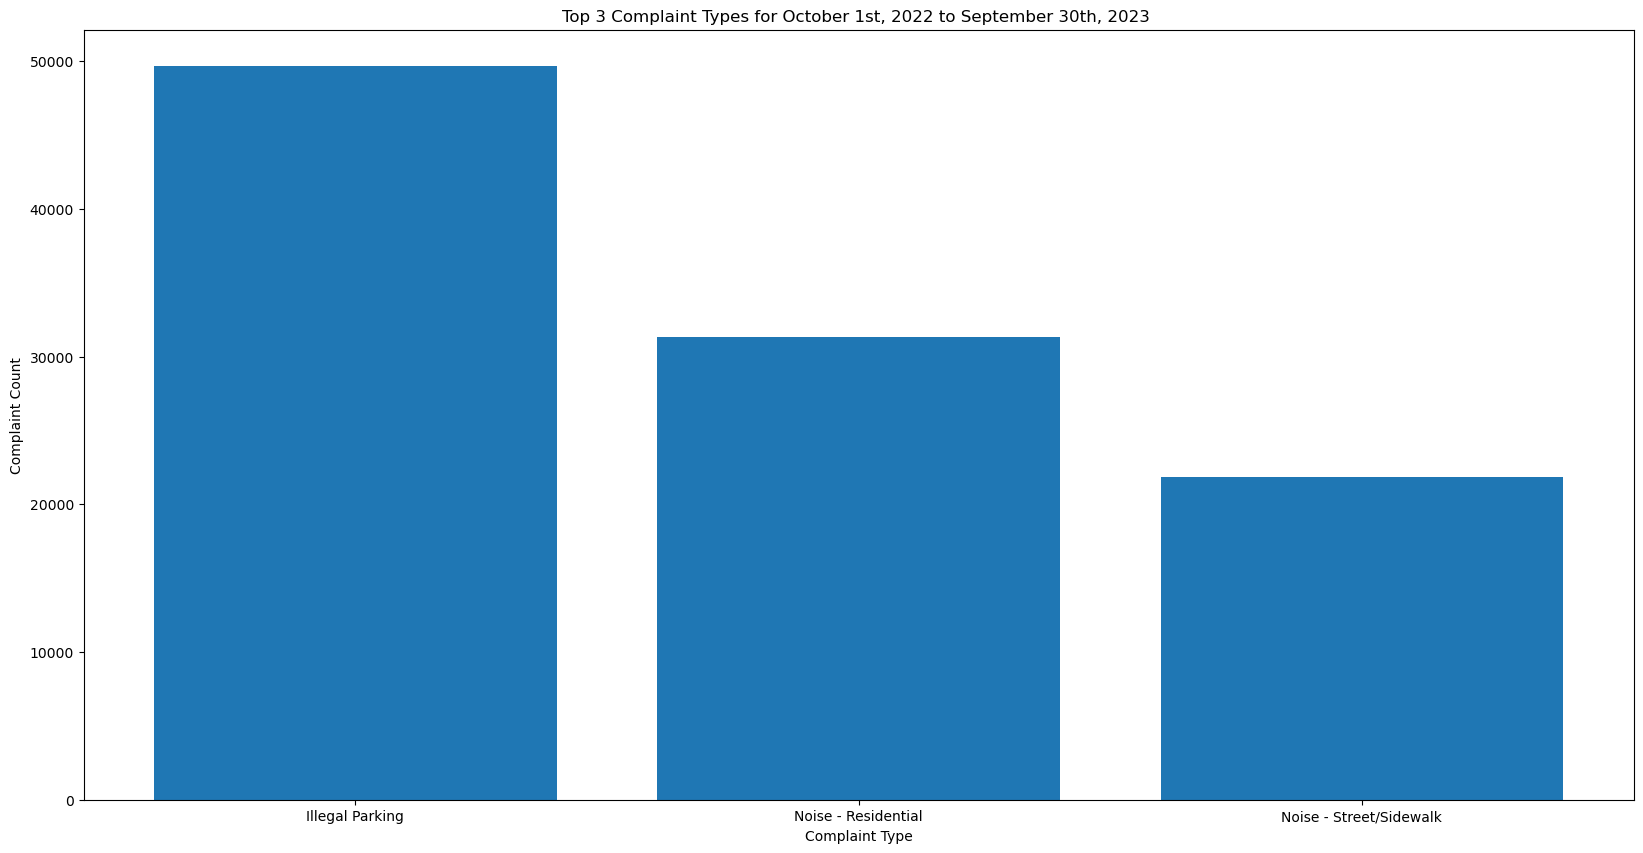

In [75]:
some_dataframe1 = get_data_for_visual_1()
plot_top_3_complaints(some_dataframe1)

### Visualization 2

In [76]:
def plot_top_10_complaints(dataframe2):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    complaint_types = dataframe2['complaint_type']
    complaint_counts = dataframe2['complaint_count']
    axes.bar(complaint_types, complaint_counts)
    axes.set_title('Top 10 Complaints in Zip Code 10027')
    axes.set_xlabel('Complaint Type')
    axes.set_ylabel('Complaint Count')
    
    plt.show()

In [79]:
def get_data_for_visual_2():
    V2 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE zipcode = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V2))
        dataframe2 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe2

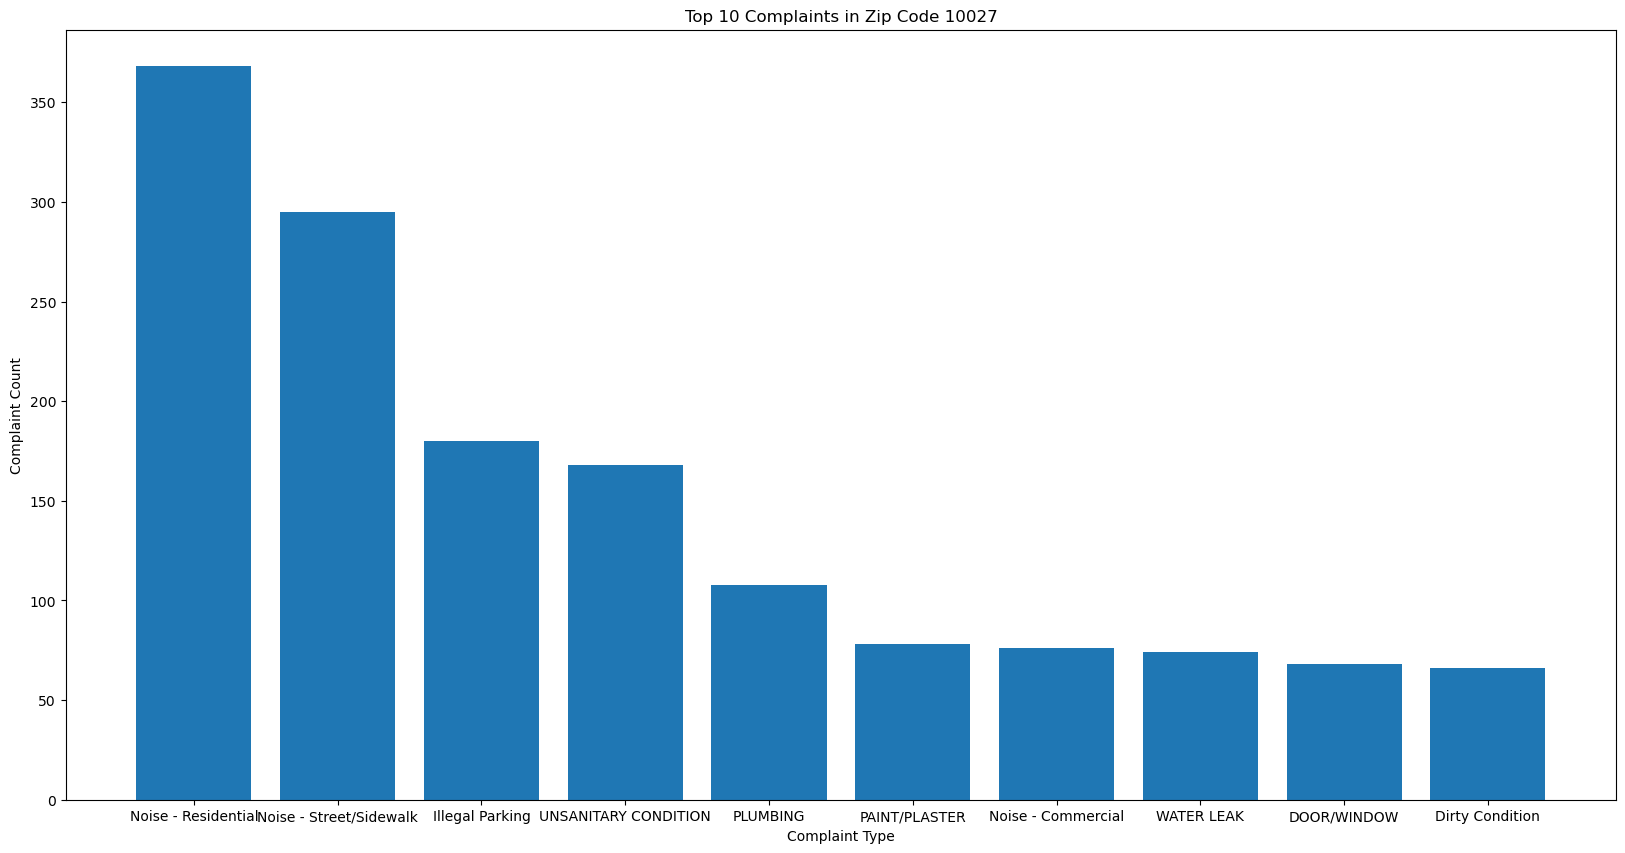

In [80]:
some_dataframe2 = get_data_for_visual_2()
plot_top_10_complaints(some_dataframe2)

### Visualization 3

In [88]:
def plot_rent_trees_complaints(dataframe3):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    # Rent & Tree Count
    ax1.scatter(dataframe3['AverageRent'], dataframe3['TreeCount'])
    ax1.set_title("Average Rent vs Tree Count")
    ax1.set_xlabel("Average Rent")
    ax1.set_ylabel("Tree Count")

    # Rent & Number of Complaints
    ax2.scatter(dataframe3['AverageRent'], dataframe3['ComplaintCount'])
    ax2.set_title("Average Rent vs Number of Complaints")
    ax2.set_xlabel("Average Rent")
    ax2.set_ylabel("Complaint Count")

    plt.show()

In [95]:
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()
Temp = """
    CREATE OR REPLACE FUNCTION TransformRentData()
    RETURNS TABLE(regionid INT, zipcode VARCHAR, month VARCHAR, average_rent NUMERIC) AS $$
    DECLARE
        start_date DATE := '2015-01-01';
        end_date DATE := '2023-09-01';
        current_date DATE := start_date;
    BEGIN
        CREATE TEMPORARY TABLE TempRentData (
            regionid INT,
            zipcode VARCHAR,
            month VARCHAR,
            average_rent NUMERIC
        );

        WHILE current_date <= end_date LOOP
            EXECUTE FORMAT(
                'INSERT INTO TempRentData (regionid, zipcode, month, average_rent) '
                'SELECT regionid, zipcode, %L, "%s" FROM rent;',
                TO_CHAR(current_date, 'YYYY-MM'), TO_CHAR(current_date, 'YYYY-MM')
            );

            current_date := current_date + INTERVAL '1 month';
        END LOOP;

        RETURN QUERY SELECT * FROM TempRentData;

        DROP TABLE TempRentData;
    END;
    $$ LANGUAGE plpgsql;

"""
with cur:
    cur.execute(Temp)

conn.commit()

SyntaxError: syntax error at or near "current_date"
LINE 23:             current_date := current_date + INTERVAL '1 month...
                     ^


In [89]:
def get_data_for_visual_3():
    V3 = """
    CALL TransformRentData();

    WITH AggregatedTrees AS (
        SELECT zipcode, COUNT(*) AS TreeCount
        FROM trees
        GROUP BY zipcode
    ),

    AggregatedComplaints AS (
        SELECT zipcode, COUNT(*) AS ComplaintCount
        FROM nyc_311
        GROUP BY zipcode
    )

    SELECT 
        tr.zipcode, 
        tr.month, 
        tr.average_rent, 
        at.TreeCount, 
        ac.ComplaintCount
    FROM 
        TempRentData tr
    LEFT JOIN 
        AggregatedTrees at ON tr.zipcode = at.zipcode
    LEFT JOIN 
        AggregatedComplaints ac ON tr.zipcode = ac.zipcode
    ORDER BY
        tr.zipcode, tr.month;
    """
   
    with engine.connect() as conn:
        result = conn.execute(db.text(V3))
        dataframe3 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe3


In [90]:
some_dataframe3 = get_data_for_visual_3()
plot_rent_trees_complaints(some_dataframe3)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "column_name" does not exist
LINE 3:         SELECT zipcode, AVG(CAST(column_name AS FLOAT)) AS A...
                                         ^

[SQL: 
    WITH RentData AS (
        SELECT zipcode, AVG(CAST(column_name AS FLOAT)) AS AverageRent
        FROM rent
        GROUP BY zipcode
    ),
    TreeData AS (
        SELECT zipcode, COUNT(tree_id) AS TreeCount
        FROM trees
        GROUP BY zipcode
    ),
    ComplaintData AS (
        SELECT zipcode, COUNT(unique_key) AS ComplaintCount
        FROM nyc_311
        WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY zipcode
    )
    SELECT r.zipcode, r.AverageRent, t.TreeCount, c.ComplaintCount
    FROM RentData r
    LEFT JOIN TreeData t ON r.zipcode = t.zipcode
    LEFT JOIN ComplaintData c ON r.zipcode = c.zipcode;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

### Visualization 4

In [ ]:
def plot_rent_vs_complaints(dataframe4):
    dataframe4['Boxplot'] = pd.cut(dataframe4['Rent'], bins=np.arange(0, dataframe4['Rent'].max() + 1000, 1000), right=False)
    
    plt.figure(figsize=(20, 10))
    dataframe4.boxplot(column='complaint_count', by='Boxplot', grid=False)
    plt.title('Rent vs Number of 311 Complaints')
    plt.xlabel('Rent')
    plt.ylabel('Complaint Count')

    plt.show()

In [ ]:
def get_data_for_visual_4():
    V4 = """
    SELECT r.zipcode, r."2023-09-30" AS Rent, COUNT(n.unique_key) AS complaint_count
    FROM nyc_311 n
    JOIN rent r ON n.zipcode = r.zipcode
    WHERE n.created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r.zipcode, r."2023-09-30"
    ORDER BY r."2023-09-30";
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V4))
        dataframe4 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe4

In [ ]:
some_dataframe4 = get_data_for_visual_4()
plot_rent_vs_complaints(some_dataframe4)

### Visualization 5

In [131]:
from shapely import wkb
import binascii
def plot_recent_311_incidents(dataframe5):
    # Convert WKB to shapely geometries
    dataframe5['geometry'] = dataframe5['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    # Extract longitude and latitude for each geometry
    dataframe5['longitude'] = dataframe5['geometry'].apply(lambda geom: geom.centroid.x)
    dataframe5['latitude'] = dataframe5['geometry'].apply(lambda geom: geom.centroid.y)

    plt.figure(figsize=(10, 10))
    plt.scatter(dataframe5['longitude'], dataframe5['latitude'], marker='o', color='blue', alpha=0.5)
    plt.title("Recent 311 Incidents in Immediate Area")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

In [132]:
def get_data_for_visual_5():
    V5 = """
    SELECT n.unique_key, n.created_date, n.zipcode, n.complaint_type, z.the_geom
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DistanceSphere(z.the_geom, ST_MakePoint(-73.96253174434912,40.80737875669467)) <= 1000;
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V5))
        dataframe5 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe5

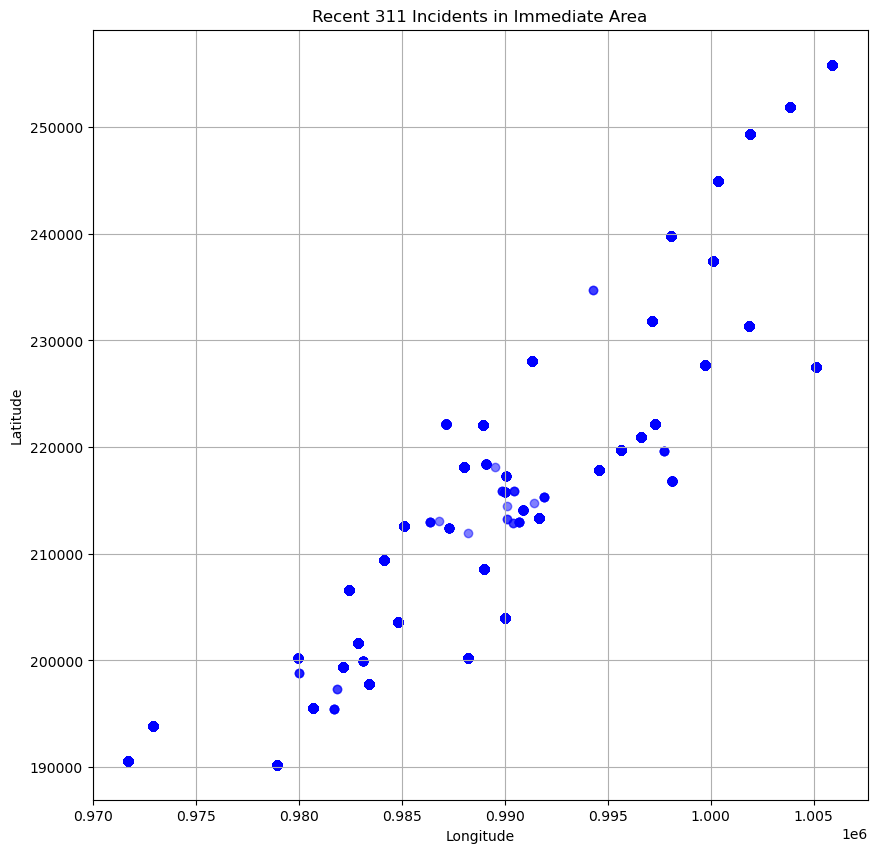

In [133]:
some_dataframe5 = get_data_for_visual_5()
plot_recent_311_incidents(some_dataframe5)

### Visualization 6

In [189]:
def plot_trees_and_complaints(tree_df, complaints_df):   
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    tree_df['geometry'] = tree_df['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    complaints_df['geometry'] = complaints_df['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))

    tree_df['longitude'] = tree_df['geometry'].apply(lambda geom: geom.centroid.x)
    tree_df['latitude'] = tree_df['geometry'].apply(lambda geom: geom.centroid.y)

    complaints_df['longitude'] = complaints_df['geometry'].apply(lambda geom: geom.centroid.x)
    complaints_df['latitude'] = complaints_df['geometry'].apply(lambda geom: geom.centroid.y)
    
    # Scatter plot for trees
    plt.scatter(tree_df['longitude'], tree_df['latitude'], marker='o', color='blue', label='Trees')
    plt.scatter(complaints_df['longitude'], complaints_df['latitude'], marker='x', color='red', label='New Tree Requests')
    
    ax.legend()
    ax.set_title('Trees and New Tree Requests in NYC')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


In [190]:
def get_data_for_visual_6():
    V6_trees = """
    SELECT tree_id, the_geom
    FROM trees;
    """

    V6_complaints = """
    SELECT n.unique_key, n.created_date, n.zipcode, n.complaint_type, z.the_geom
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2018-10-01' AND '2023-09-30'
    AND complaint_type = 'New Tree Request';
    """

    with engine.connect() as conn:
        trees_result = conn.execute(db.text(V6_trees))
        complaints_result = conn.execute(db.text(V6_complaints))

        trees_df = gpd.GeoDataFrame(trees_result.fetchall(), columns=trees_result.keys())
        complaints_df = gpd.GeoDataFrame(complaints_result.fetchall(), columns=complaints_result.keys())

    return trees_df, complaints_df

/var/folders/rt/64820s912t1fxfz6z7jsd8rr0000gn/T/ipykernel_71162/126589364.py:5: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  tree_df['geometry'] = tree_df['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
/var/folders/rt/64820s912t1fxfz6z7jsd8rr0000gn/T/ipykernel_71162/126589364.py:6: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoData

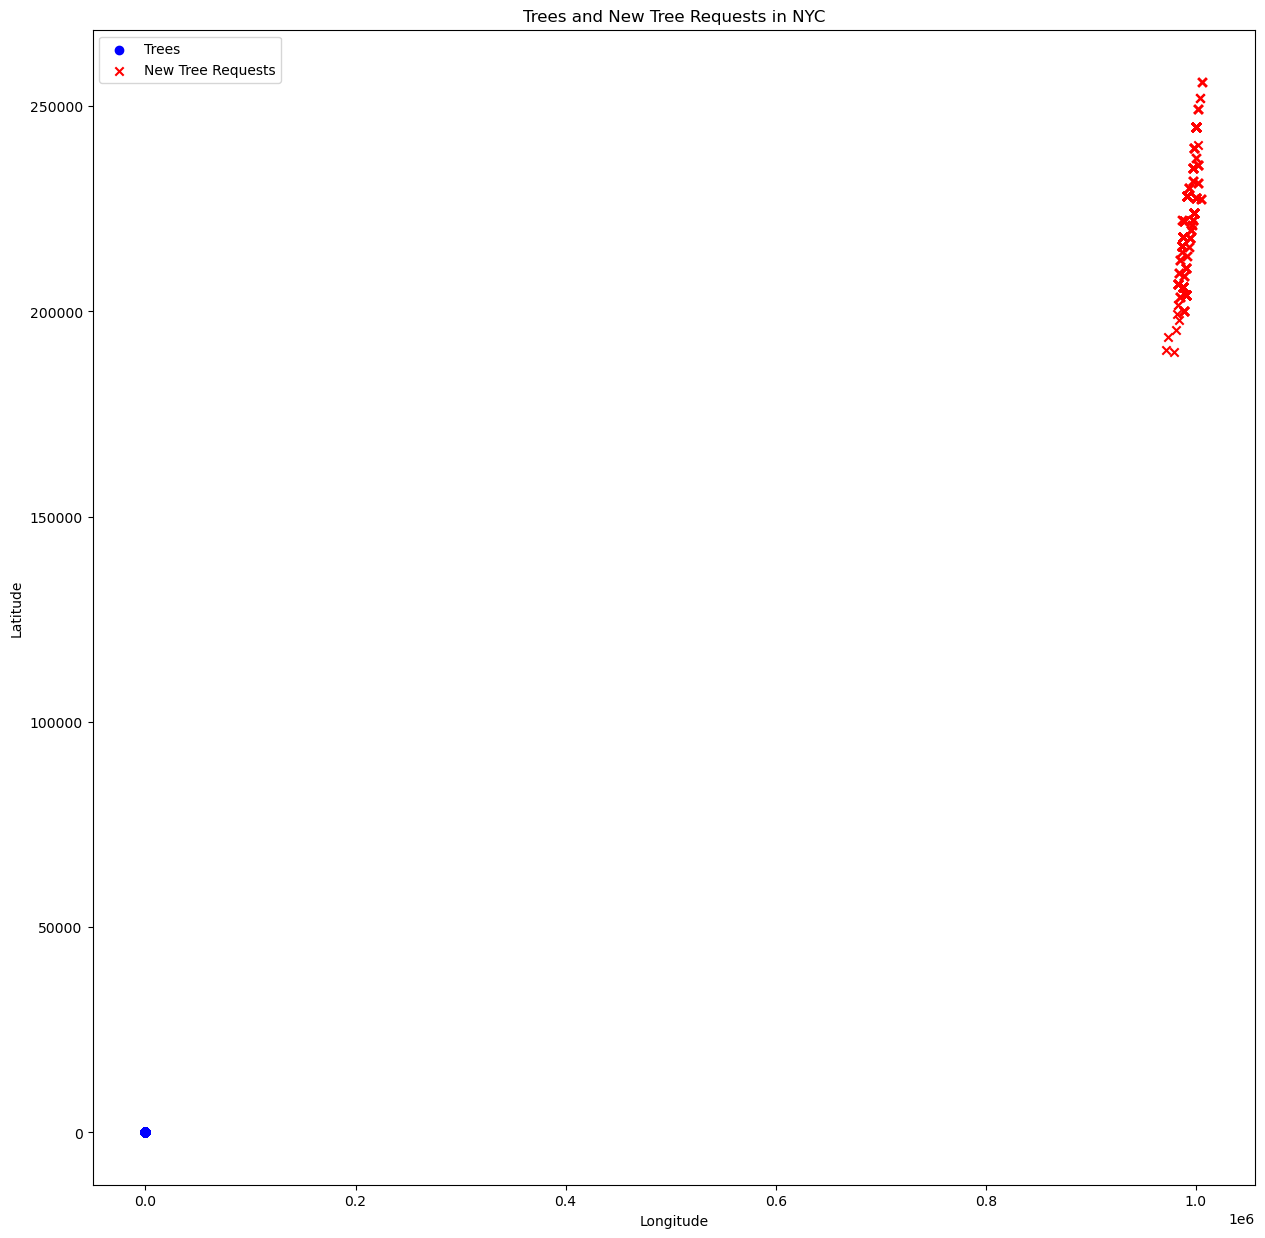

In [191]:
some_trees_df, some_complaints_df = get_data_for_visual_6()  
plot_trees_and_complaints(some_trees_df, some_complaints_df)